
# Clustering text documents using k-means and dimensionality reduction


This is an example showing how dimensionality reduction can mitigate the "curse of dimensionality", by denoising data and improving performance of euclidean-based clustering approaches. In this example, we cluster a set of documents, represented as bag-of-worids, using two approaches:
1. A standard k-means algorithm (k-means++)
2. We apply k-means after reducing the dimensionality of the space via application of a truncated SVD

We use standard measures of clustering quality to compare results provided by the two approaches.

## Datasets
To test our ideas, we begin with some standard datasets, for which ```sklearn``` provides a class for automatic downloading and preprocessing. 
As stated in the description, "The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date." Please refer to http://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset for more information.

To begin with, we import the libraries we will be using in this notebook:

## Our goal
Given a collection containing documents from $k$ different topics ($k = 3$ in this example), we want to extract the $10$ "most important" terms for each topic. We will consider 3 approaches:
1. The first is a pure clustering method: we treat each document as a point in feature space (features are the terms) and we apply a standard $k$-means algorithm. Each of the $k$ centroids thus obtained represents the "typical" document for the corresponding topic. We identify the terms that correspond to the $10$ largest entries.
2. The second is a purely SVD-based approach. We compute the first $k$ components of the SVD of the data matrix, setting $k$ to the number of topics in the subcollection we downloaded ($k = 3$ in this example). The underlying assumption is that the $k$ main singular vectors are correlated with the subcollection's topics. This turns out to be true in this example, although it does not have to always be the case.
3. The third is a hybrid approach, in which data are first projected onto a subspace in $k$ dimensions using an SVD, so that each original point $\mathbf{x}$ now corresponds to a vector $\hat{\mathbf{x}}$, with $\hat{\mathbf{x}}_i$ the component of $\hat{\mathbf{x}}$ along the $i$-th right singular vector. We then apply $k$-means to the projected points. The underlying idea is that the entries of vectors in projected space, corresponding to documents on the same topic, are correlated. After performing clustering, we again have $k$ centroids in projected space. We identify the points corresponding to these centroids in the original space (see following paragraphs about how this is done) and we then proceed like in point 1. above.

## How to proceed
We next describe the main steps for the implementation of the solutions mentioned above. Note that we are not implementing the obvious, naive solution, that directly uses the label/topic of each document to retrieve the most important words for each topic. It could be interesting to compare the results with those of this simple solution, based on the ground truth.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np

The class ```TruncatedSVD``` implements truncated SVD. ```TfidfVectorizer``` as usual is used to convert a collection of documents, represented as a list of strings, into the corresponding tf-idf matrix. ```Normalizer``` provides utilities for vector normalization, while ```make_pipeline``` allows to pipeline two or more estimators. In our case, we will use a pipelinine consisting of a first stage performing a low-rank approximation of the dataset, followed by an application of k-means to projected data.

We first select some categories from the 20 newsgroups dataset. These are specified by a list of string descriptors:

In [2]:
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


We next download the corresponding dataset:

In [3]:
dataset = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

Here, ```subset='all'``` means the dataset is downloaded in its entirety and is not split into a training and test set, which we do not need in this case. Documents are not randomly reordered (```Shuffle=False```) and we remove all metadata, leaving only body text. ```dataset``` is an object describing the dataset. Its attributes ```filenames``` and ```target``` are two arrays, respectively containing the paths to the different documents and the corresponding labels, represented as integers from ```0``` to ```len(categories) - 1```.

In [4]:
labels = dataset.target
true_k = len(np.unique(labels)) ## This should be 3 in this example

### Point 4: Preliminary cleanup of the dataset

First we find out which are the words less used

In [5]:
import pandas as pd
from collections import defaultdict
import re

In [6]:
num_doc_threshold = 5

words_stat = defaultdict(lambda: [0, 0, []])

for i in range(len(dataset.data)):
    for word in list(set(re.split('\W+', dataset.data[i]))):
        words_stat[word][0] += dataset.data[i].count(word)
        words_stat[word][1] += 1
        if words_stat[word][1] <= num_doc_threshold: words_stat[word][2].append(i)
        else: words_stat[word][2] = None

del words_stat[""]

df = pd.DataFrame.from_dict(words_stat, orient="index", columns=["frequency", "num_doc", "documents"])

Then we create an inverted index. <br>
So that we know for each document which word we have to remove

In [7]:
doc_and_words = defaultdict(lambda: [])

for word, document_ids in df[(df["frequency"]<=num_doc_threshold) & (df["num_doc"]<=num_doc_threshold)]["documents"].iteritems():
    for doc_id in document_ids:
        doc_and_words[doc_id].append(word)

Finally we scan through the documents that contains those rare words and delete them.

In [8]:
doc_to_inspect = list(set(np.concatenate(df[(df["frequency"]<=num_doc_threshold) & (df["num_doc"]<=num_doc_threshold)]["documents"].values)))

for doc_id, words in doc_and_words.items():
    regex = re.compile(rf"\W{'|'.join(words)}\W")
    dataset.data[doc_id] = re.sub(regex, " ", dataset.data[doc_id])


We first perform lemmatization, which seems to behave better than stemming. The reason might be that the latter is too "aggressive" for this collection, consisting of short documents that may contain misspells, abbreviations etc. You would probably experience similar problems with a corpus of Twitter posts. You can try with stemming after commenting the next block of code

In [9]:
lemmatizer = WordNetLemmatizer()
for i in range(len(dataset.data)):
    word_list = word_tokenize(dataset.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    dataset.data[i] = lemmatized_doc  

### Point 1: Use CountVectorizer instead of the Tf-Idf

We next convert our corpus with CountVectorizer:

In [10]:
vectorizer = CountVectorizer(stop_words='english') ## Corpus is in English
X = vectorizer.fit_transform(dataset.data)

We next check the data matrix shape. Note that points/documents correspond to rows, while terms correspond to columns

In [11]:
print(X.shape)

(2588, 6793)


## Take 1: using standard k-means
We first cluster documents using the standard k-means algorithm (actually, a refined variant called k-means++), without any further date preprocessing. The key parameter of choice when performing k-means is $k$. Alas, there really is no principled way to choose an initial value for $k$. Essentially we have two options:

1. We choose a value that reflects our knowledge about the data, as in this case
2. We try several value, possibly in increasing order. We proceed this way as long as the quality of the resulting clustering (as measured by one or more quality indices) increases. We stop when it starts decreasing. As you may suspect, this case arises pretty often in practice

In this specific case, we set $k = 3$ of course

In [12]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

done in 0.260s


We next take some standard measure of cluster quality. Please refer to ```sklearn.metrics``` documentation for details.

In [13]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.004
Completeness: 0.137
V-measure: 0.007
Adjusted Rand-Index: -0.001
Silhouette Coefficient: 0.931


In a nutshell, the above results are saying that we achieve some degree of clustering, but this is far from optimal. In particular, there is a certain degree of overlap among different cluster, with many pairs of documents from the same category assigned to different partitions

We finally identify the 10 most relevant terms in each cluster. Intuitively, these are the ones that correspond to entries of largest magnitude in the centroids

In [14]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: image edu data graphics pub ftp file available format package
Cluster 1: wa space ha like know image just time god people
Cluster 2: jpeg image file gif color format version program quality bit


## Take 2: Using singular vectors
We next project data onto the subspace(s) corresponding to the $k$ main components ($k = 3$ in this case). We then identify the words corresponding to the $10$ largest components (with sign) of the right singular vector. The reason for using right singular vectors is that the $i$-th such vector is the representation of the $i$-th topic in feature space (features are terms in our case). We project input data onto a lower dimensional space using ```TruncatedSVD```. We first check the number of dimensions/features in the original dataset

In [15]:
print("The original data have", X.shape[1], "dimensions/features/terms")

The original data have 6793 dimensions/features/terms


We next choose the number of dimensions in projected space, i.e., the number of singular values (equivalently, the number of singular vector pairs) we intend to retain. Here, we can proceed in a more or less principled way:

1. The first way is experimenting with different, increasing values for the number of dimensions, until experimental results (in our case, cluster quality after application of k-means) are satisfactory
2. The second, more principled approach is choosing a value $r$ for the number of dimensions to retain, such that $\sum_{i=1}^r\sigma_i^2\ge \alpha\sum_{i=1}^{\min\{m, n\}}\sigma_i^2$. In practice, we do not want to compute all singular values in advance, even though this is cheaper than also computing singular vectors. Another heuristic approach is stopping the first time that $\sigma_{i+1}/\sigma_i\le\beta$, for a suitably small $\beta$
3. Finally, if clusters are well-separated, the first $k$ singular vectors will themselves reflect cluster structure. In this case, one can try to take $r = k$. 

In our case we use $r = 3$, with the idea that the $k$ main singular vector correspond the main topics of our collection. We get a good match, but we can do better (see below)

### Point 2: Explained variance

we take all the singular values for the moment, we want to see how the explained variance behaves.

done in 0.527698s, 100 singular values


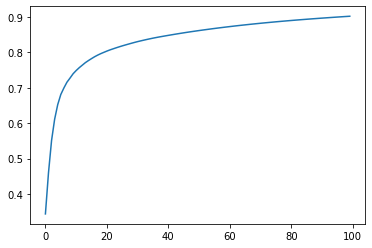

In [16]:
# in order to have a better view we plot only the first 100 singular values
r = 100
t0 = time()
svd = TruncatedSVD(r)
svd.fit(X)
print("done in %fs, %i singular values" % (time() - t0, r))

import matplotlib.pyplot as plt

plt.plot(svd.explained_variance_ratio_.cumsum())
plt.show()

### Point 3: Centering the dataset before SVD

before apply the SVD on the dataset ve center it, will be like performing the PCA

In [17]:
r = true_k
t0 = time()
svd = TruncatedSVD(r)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
centered_X = X - X.mean(axis=0)
Y = lsa.fit_transform(centered_X)
print("done in %fs" % (time() - t0))
var = 0

done in 1.034527s


What happened? Consider the original tf-idf matrix (i.e., ```X``` before application of ```TruncatedSVD```). Let us call $X$ this matrix. We have $X = U\Sigma V^T$. By computing ```TruncatedSVD```, we only kept the first $r$ singular values/singular vector pairs. How did we project? Simply put, we projected the row corresponding to each document onto the subspace spanned by the first $r\ (= k)$ right singular vectors. More in detail, note that right-multiplying both members of the equation above by $V_r$ gives $XV_r = U_r\Sigma_r$. Hence, the projection $\hat{X}_{j*}$ of the $j-th$ row (document) of $X$ onto the "concept space" is given by:

$$\hat{X}_{j*} = X_{j*}V_r$$

Note that, consistently, $\hat{X}_{j*}$ is now a vector with $r$ components. Let's check:

In [18]:
print("The number of documents is still", Y.shape[0])
print("The number of dimension has become", Y.shape[1])

The number of documents is still 2588
The number of dimension has become 3


### Finding the most important features/terms in every topic (first try)

In [19]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)

Topic 0: 
image jpeg file format gif color edu program version available 
Topic 1: 
edu pub data graphics ftp mail 128 ray 3d send 
Topic 2: 
jehovah god elohim lord father christ mcconkie wa jesus son 


SVD seems to have done a very good job (better than $k$-means) for topics 1 and 2, while the most representative words for topic 0 are far less impressive. Maybe, more information can be extracted if we consider that singular vectors are defined up to their signs. In particular, consider the SVD expansion of a given matrix $A$:
$$
    A = \sum_i\sigma_i\mathbf{u}_i\mathbf{v}_i^T
$$
The generic, $i$-th projector $\mathbf{u}_i\mathbf{v}_i$ does not change if you consider the singular vectors $-\mathbf{u}_i$ and $-\mathbf{v}_i$ (notice that you have to change signs to both!). Signs, in some sense, express degrees of correlation. In our case, since the original points have non-negative entries (they are term frequencies), negative entries on a right singular vector's component corresponding to a given term denotes a negative correlation of the corresponding topic with the term. Let us try to put this intuition in practice, by considering, for each singular vectors, the most important terms if we consider both ascending and descending ordering of the entries:

In [20]:
terms = vectorizer.get_feature_names()

for i in range(svd.components_.shape[0]):
    terms_comp = [[terms[j], svd.components_[i][j]] for j in range(svd.components_.shape[1])]
    asc_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    des_terms = sorted(terms_comp, key= lambda x:x[1], reverse=False)[:10]
    print("Topic "+str(i)+": ")
    s = ""
    for t in asc_terms:
        s += t[0] + " "
    print(s)
    s = ""
    for t in des_terms:
        s += t[0] + " "
    print(s)

Topic 0: 
image jpeg file format gif color edu program version available 
koresh kent moral den cheers p2 p3 p1 oh morality 
Topic 1: 
edu pub data graphics ftp mail 128 ray 3d send 
jpeg gif color quality file viewer jfif bit setting version 
Topic 2: 
jehovah god elohim lord father christ mcconkie wa jesus son 
edu graphics pub mail ftp 128 image data 3d ray 


The results are now impressive again. Apparently, the "space" topic can be obtained by considering the words that are less correlated with the topic "religion", which also seems to be negatively correlated with "computer graphics"

## Take 3: Clustering projected data
We next use again k-means, but we first project the input data onto a lower dimensional space using ```TruncatedSVD```. We first check the number of dimensions/features in the original dataset

We now apply k-means to the projected data and collect quality statistics

In [21]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(Y)
print("done in %0.3fs" % (time() - t0))
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Y, km.labels_, sample_size=1000))

done in 0.130s

Homogeneity: 0.060
Completeness: 0.108
V-measure: 0.078
Adjusted Rand-Index: 0.021
Silhouette Coefficient: 0.692


We next identify the terms that are most relevant in each cluster, as identified by applying ```TruncatedSVD``` first and k-means afterwards. Note that we face a problem here. Centroids are now in projected space and thus each have $r$ components, corresponding to the dimensions of the concept space and hard. To verify this:

In [22]:
print(km.cluster_centers_.shape)

(3, 3)


So, correctly we have $k$ centroids, each with $r$ coordinates. In some way, we need to "project" these back to the original space. We argue in the following way. Assume $\hat{C}_j$ is the $j$-th centroid. We look for a vector $C_j$ in the original space that yields $\hat{C}_j$ when projected onto the concept space. Note that vectors in the original space have $n$ features (with $n$ the number of terms in our case), so they are projected using the *right* singular vectors. As a result, $C_j$ has to satisfy the following equality:

$$\hat{C_j}^T = C_j^TV_r$$

Right-multiplying both members by $V^T$ we obtain $C_j^T = \hat{C}_j^TV_r^T$. Note that $V_rV_r^T$ is diagonal and its number of components is consistent with the number of components $C_j$ is supposed to have. In our case, this very operation is performed by the method ```TruncatedSVD.inverse_transform()```. Let us check this.

In [23]:
original_centroids = svd.inverse_transform(km.cluster_centers_)
print(original_centroids.shape) ## Just a sanity check
for i in range(original_centroids.shape[0]):
    original_centroids[i] = np.array([x for x in original_centroids[i]])
svd_centroids = original_centroids.argsort()[:, ::-1]

(3, 6793)


We can finally identify the 10 most relevant terms for each centroid

In [24]:
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in svd_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: jehovah god elohim lord father christ mcconkie wa jesus son
Cluster 1: image edu file graphics pub data ftp format available mail
Cluster 2: cheers hello den advance p3 p2 kent p1 prize detector


The results we get are in some way intermediate between ones obtained with the first two approaches